# 0. Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from helpers import read_hdf5, CombineDataset, calculate_metrics, train_net, test_net
from lenshelpers import Residual

from model.baseline import CNNNetBasic, TabularNetBasic, TabularCNNNetBasic
from model.densenet import densenet161
from model.alexnet import AlexNetResidual
from model.resnet18 import resnet18maps
from model.vgg16 import VGG16Residual
from model.googLeNet import googlenet, GoogLeNet
from model.squeezeNet import squeezenet1_1

import warnings
warnings.filterwarnings('ignore') 

# 1. Building the data set

In [2]:
# Build the four classes 
config_repo_model = 'data/configFile/config_model'
ratio = 0.75
percent = 0.01

size = 900
for i in np.arange(1,4):
    #model_name = config_repo_model + str(i) + '.yaml'
    res = Residual()
    res.build(size, i, ratio = ratio, per_error = percent)

print('Data Generation Finished')

Data Generation Finished


In [3]:
metadata = pd.DataFrame()

for i in np.arange(1,4):
    str_ID = "E"+str(i)+"P"+str(int(percent*100))+"R"+str(int(ratio*100))
    [img, meta] = read_hdf5(str_ID, path = "data/dataSet/")
    metadata = pd.concat([metadata,meta], ignore_index=True)
    if i == 1:
        final_array = img
    else:
         final_array = np.concatenate((final_array, img))
metadata ['ID'] = np.arange(0,final_array.shape[0])
data_set = CombineDataset(metadata,'ID','class',final_array)

print('Reading Data Finished')
data_train, data_test = train_test_split(data_set,train_size=0.9,random_state=42)

Reading Data Finished


In [4]:
batch_size_train = 10
batch_size_test = 10
max_epoch = 20


loader_train = DataLoader(data_train, batch_size = batch_size_train, shuffle = True, 
                          num_workers = 0, drop_last=True)

loader_test = DataLoader(data_test, batch_size = batch_size_test, shuffle = True, 
                         num_workers = 0, drop_last=True)

# 2. Baseline

## 2.1. Residual network

**Results** : 6 epochs - 0.993 accuracy

In [5]:
net = CNNNetBasic()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
test_acc = np.zeros(max_epoch)
max_acc = 0
# Optimal number of epochs : 6 epochs - 0.993 accuracy
for epoch in range(max_epoch):  # loop over the dataset multiple times

    net = train_net(loader_train, net, optimizer, criterion, epoch)
    mean_accuracy = test_net(loader_test,net)
    test_acc[epoch] = mean_accuracy
    if mean_accuracy > max_acc:
        max_acc = mean_accuracy
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, mean_accuracy))
print('Finished Training')

epoch: 0.000, accuracy: 0.278 
epoch: 6.000, accuracy: 0.311 
epoch: 8.000, accuracy: 0.522 
epoch: 10.000, accuracy: 0.578 
epoch: 12.000, accuracy: 0.656 
epoch: 15.000, accuracy: 0.678 
epoch: 19.000, accuracy: 0.689 
Finished Training


## 2.2. Metadata network
**Results** : 4 epochs - 0.865 accuracy 

In [7]:
net = TabularNetBasic()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
test_acc_meta = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    net = train_net(loader_train, net, optimizer, criterion, epoch)
    mean_accuracy = test_net(loader_test,net)
    test_acc_meta[epoch] = mean_accuracy
    if mean_accuracy > max_acc:
        max_acc = mean_accuracy
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, mean_accuracy))
        
print('Finished Training')

epoch: 0.000, accuracy: 0.056 
epoch: 1.000, accuracy: 0.256 
Finished Training


## 2.3. Tabular & Residual network
**Results** : 8 epochs -  0.995 accuracy

In [9]:
net = TabularCNNNetBasic()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
test_acc_metaxres = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    net = train_net(loader_train, net, optimizer, criterion, epoch)
    mean_accuracy = test_net(loader_test,net)
    test_acc_metaxres[epoch] = mean_accuracy
    if mean_accuracy > max_acc:
        max_acc = mean_accuracy
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, mean_accuracy))
        
print('Finished Training')

epoch: 0.000, accuracy: 0.167 
epoch: 3.000, accuracy: 0.189 
epoch: 6.000, accuracy: 0.211 
epoch: 8.000, accuracy: 0.256 
epoch: 12.000, accuracy: 0.311 
epoch: 13.000, accuracy: 0.456 
epoch: 15.000, accuracy: 0.511 
Finished Training


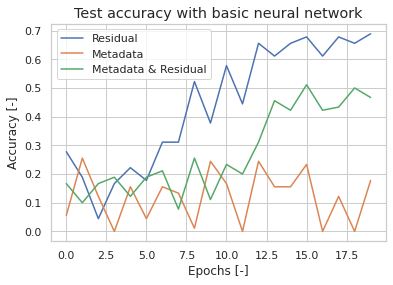

In [11]:
import seaborn as sns
sns.set_theme(style="whitegrid")

sns.lineplot(x=np.arange(0,max_epoch), y=test_acc, label = 'Residual')
sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_meta, label = 'Metadata')
sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_metaxres, label = 'Metadata & Residual')

plt.xlabel('Epochs [-]')
plt.ylabel('Accuracy [-]')
plt.title('Test accuracy with basic neural network', size = 'large')
plt.savefig('figures/basicS3000P1.jpeg')

# 3. Building different model

## 3.1. AlexNet - Residual maps
### 3.1.2 Padding
**Results** :  epochs -  accuracy 

In [12]:
net = AlexNetResidual()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
test_acc_pad = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        m = nn.ZeroPad2d(80)
        inputs = m(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    iteration = 0
    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            m = nn.ZeroPad2d(80)
            images = m(images)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_pad[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

epoch: 0.000, accuracy: 0.289 
epoch: 4.000, accuracy: 0.344 
epoch: 13.000, accuracy: 0.433 
Finished Training


### 3.1.2. Interpolation

**Results** :  epochs -  accuracy 

In [14]:
net = AlexNetResidual()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
test_acc_int = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        inputs = F.interpolate(inputs, size=(224, 224), mode='bicubic', align_corners=False)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            images = F.interpolate(images, size=(224, 224), mode='bicubic', align_corners=False)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_int[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

epoch: 0.000, accuracy: 0.178 
epoch: 1.000, accuracy: 0.189 
epoch: 2.000, accuracy: 0.244 
epoch: 4.000, accuracy: 0.333 
epoch: 5.000, accuracy: 0.533 
epoch: 9.000, accuracy: 0.567 
epoch: 10.000, accuracy: 0.600 
epoch: 16.000, accuracy: 0.656 
Finished Training


Text(0, 0.5, 'Accuracy [-]')

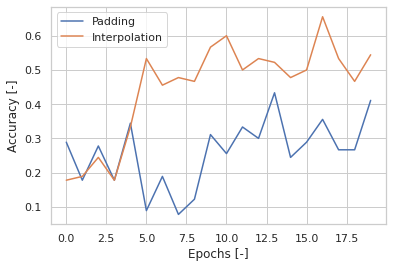

In [16]:
sns.set_theme(style="whitegrid")

sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_pad, label = 'Padding')
sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_int, label = 'Interpolation')
# change legend texts
plt.xlabel('Epochs [-]')
plt.ylabel('Accuracy [-]')

## 3.2. Resnet18 - Residual maps
### 3.2.1. Padding
**Results** :  epochs -  accuracy 

In [17]:
net = resnet18maps(1,3)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
test_acc_pad = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        m = nn.ZeroPad2d(80)
        inputs = m(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            m = nn.ZeroPad2d(80)
            images = m(images)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_pad[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

epoch: 0.000, accuracy: 0.222 


KeyboardInterrupt: 

### 3.2.2. Interpolation
**Results** :  epochs -  accuracy 

In [ ]:
net = resnet18maps(1,3)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test_acc_int = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        inputs = F.interpolate(inputs, size=(224, 224), mode='bicubic', align_corners=False)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    accuracy = 0
    iteration = 0
    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            images = F.interpolate(images, size=(224, 224), mode='bicubic', align_corners=False)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_int[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

In [ ]:
sns.set_theme(style="whitegrid")

sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_pad, label = 'Padding')
sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_int, label = 'Interpolation')
# change legend texts
plt.xlabel('Epochs [-]')
plt.ylabel('Accuracy [-]')

## 3.3. VGG16 - Residual maps
### 3.3.1. Padding
**Results** :  epochs -  accuracy 

In [ ]:
net = VGG16Residual()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test_acc_pad = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        m = nn.ZeroPad2d(80)
        inputs = m(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            m = nn.ZeroPad2d(80)
            images = m(images)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_pad[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

### 3.3.2 Interpolation
**Results** :  epochs -  accuracy 

In [ ]:
net = VGG16Residual()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test_acc_int = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        inputs = F.interpolate(inputs, size=(224, 224), mode='bicubic', align_corners=False)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            images = F.interpolate(images, size=(224, 224), mode='bicubic', align_corners=False)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_int[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

In [ ]:
sns.set_theme(style="whitegrid")

sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_pad, label = 'Padding')
sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_int, label = 'Interpolation')
# change legend texts
plt.xlabel('Epochs [-]')
plt.ylabel('Accuracy [-]')

## 3.4. Dense Net 161 - Residual maps
### 3.4.1 Padding
**Results** :  epochs -  accuracy 

In [ ]:
net = densenet161()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test_acc_pad = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        m = nn.ZeroPad2d(80)
        inputs = m(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            m = nn.ZeroPad2d(80)
            images = m(images)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_pad[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

### 3.4.2 Interpolation
**Results** :  epochs -  accuracy 

In [ ]:
net = densenet161()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test_acc_int = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        inputs = F.interpolate(inputs, size=(224, 224), mode='bicubic', align_corners=False)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    accuracy = 0
    iteration = 0
    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            images = F.interpolate(images, size=(224, 224), mode='bicubic', align_corners=False)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_int[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

In [ ]:
sns.set_theme(style="whitegrid")

sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_pad, label = 'Padding')
sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_int, label = 'Interpolation')
# change legend texts
plt.xlabel('Epochs [-]')
plt.ylabel('Accuracy [-]')

## 3.5. Google Net - Residual maps
### 3.5.1 Padding
**Results** :  epochs -  accuracy 

In [ ]:
net = GoogLeNet(googlenet(True, True, None,224, dropout_rate=0.2, num_classes=3))
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test_acc_pad = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        m = nn.ZeroPad2d(80)
        inputs = m(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux1, aux2 = net(inputs)
        loss = criterion((outputs+aux1+aux2)/3, labels)
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            m = nn.ZeroPad2d(80)
            images = m(images)
            outputs,aux1,aux2 = net(images)
            outputs = (outputs+aux1+aux2)/3
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_pad[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

### 3.5.2 Interpolation
**Results** :  epochs -  accuracy 

In [ ]:
net = GoogLeNet(googlenet(True, True, None,224, dropout_rate=0.2, num_classes=3))
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test_acc_int = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        inputs = F.interpolate(inputs, size=(224, 224), mode='bicubic', align_corners=False)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux1, aux2 = net(inputs)
        loss = criterion((outputs+aux1+aux2)/3, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            images = F.interpolate(images, size=(224, 224), mode='bicubic', align_corners=False)
            outputs,aux1,aux2 = net(images)
            outputs = (outputs+aux1+aux2)/3
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_int[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

In [ ]:
sns.set_theme(style="whitegrid")

sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_pad, label = 'Padding')
sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_int, label = 'Interpolation')
# change legend texts
plt.xlabel('Epochs [-]')
plt.ylabel('Accuracy [-]')

## 3.6. Squeeze Net 1_1  - Residual maps
### 3.6.1 Padding
**Results** :  epochs -  accuracy 

In [ ]:
net = squeezenet1_1()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test_acc_pad = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        m = nn.ZeroPad2d(80)
        inputs = m(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            m = nn.ZeroPad2d(80)
            images = m(images)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_pad[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

### 3.6.2 Interpolation
**Results** :  epochs -  accuracy 

In [ ]:
net = squeezenet1_1()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test_acc_int = np.zeros(max_epoch)
max_acc = 0
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, meta_inputs,labels = data
        inputs = F.interpolate(inputs, size=(224, 224), mode='bicubic', align_corners=False)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta_img, labels = data
            images = F.interpolate(images, size=(224, 224), mode='bicubic', align_corners=False)
            outputs = net(images)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
        result = calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        test_acc_int[epoch] =  result['accuracy']
    if result['accuracy'] > max_acc:
        max_acc = result['accuracy']
        print("epoch: {:.3f}, accuracy: {:.3f} ".format(epoch, result['accuracy']))
    
print('Finished Training')

In [ ]:
sns.set_theme(style="whitegrid")

sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_pad, label = 'Padding')
sns.lineplot(x=np.arange(0,max_epoch), y=test_acc_int, label = 'Interpolation')
# change legend texts
plt.xlabel('Epochs [-]')
plt.ylabel('Accuracy [-]')